In [1]:
import glob
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__)

numpy version:  1.12.1
astropy version:  3.1.dev21448
asdf version:  1.3.2.dev1202
gwcs version:  0.9.dev306
jwst version:  0.9.1a.dev42


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from jwst import datamodels
from jwst.assign_wcs.nirspec import nrs_wcs_set_input
import test_nrs_ifu

### Test 1

For each Trace file:
- Compute the pixel indices (x, y) for values in the SLIT extension that are between -0.5 and 0.5 (within the slit).
- Get the wavelength values for these pixels from the LAM extension.
- Transfer these (x, y) to full frame coordinates using the FITS WCS in the Trace file.
- Evaluate the pipeline WCS passing these x, y as input to obtain ra, dec, lam from the pipeline code.
- Compute the difference between the ESA and pipeline wavelengths for these x, y pixels.

In [4]:
# Create a list of all TRACE* files from ESA. The files are expected to be in the a subdirectory called "esa".
esa = glob.glob("esa/*.fits")
pipeline_file = "ifu_assign_wcs.fits"

In [5]:
test_nrs_ifu.test_slits_esa_coords('ifu_assign_wcs.fits', esa)


Running test for slice 0
Number of pixels with NaN values in the diff:  60
Number of pixels with values of <= 10**-13 in the diff:  43538
Slice 0, max diff in wavelength:  2.79524047909e-13
Slice 0, max diff along slit y-axis:  0.000238704487856
Slice 0, max diff in MSA x coordinate:  0.499525245746
Slice 0, max diff in MSA y coordinate:  0.499525245746

Running test for slice 1
Number of pixels with NaN values in the diff:  29
Number of pixels with values of <= 10**-13 in the diff:  43485
Slice 1, max diff in wavelength:  2.92249795522e-13
Slice 1, max diff along slit y-axis:  0.00028565419484
Slice 1, max diff in MSA x coordinate:  0.499584801615
Slice 1, max diff in MSA y coordinate:  0.499584801615

Running test for slice 2
Number of pixels with NaN values in the diff:  30
Number of pixels with values of <= 10**-13 in the diff:  43609
Slice 2, max diff in wavelength:  4.9081448579e-13
Slice 2, max diff along slit y-axis:  0.000276546405701
Slice 2, max diff in MSA x coordinate:  0

### Test 2

For each slice:

- Take the lam extension and transform the indices to (x,y) coordinates using its WCS.
- Compute RA, DEC, lambda by evaluating the pipeline WCS object on these (x, y).
- Display the difference between the two wavelength arrays.

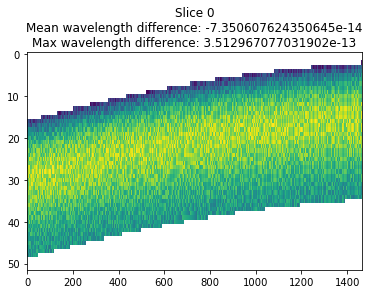

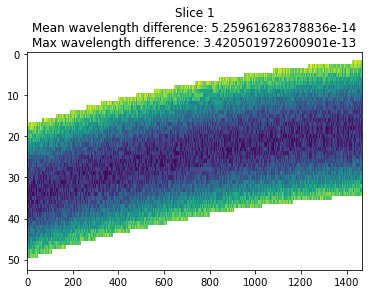

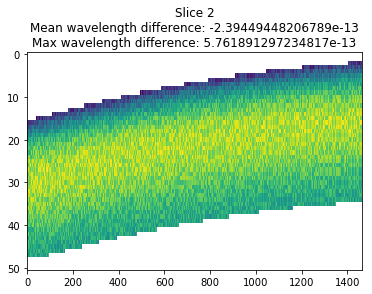

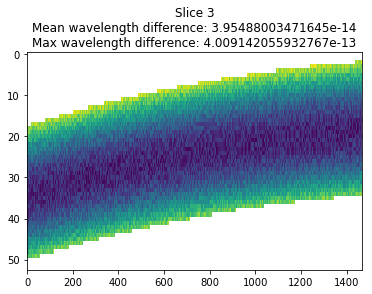

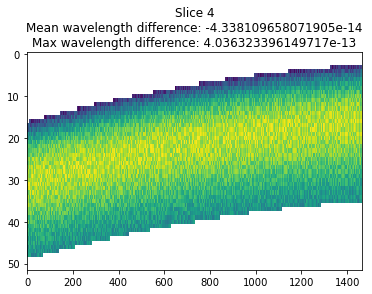

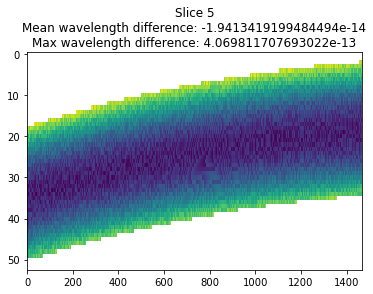

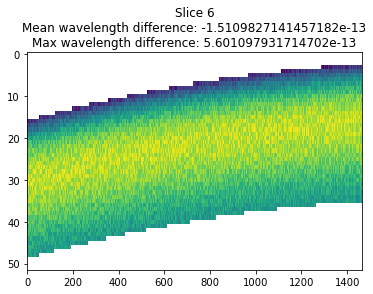

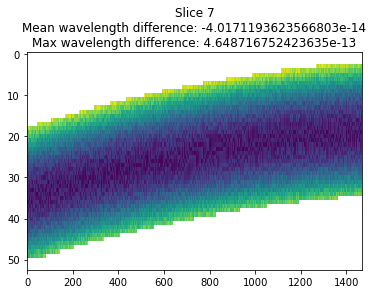

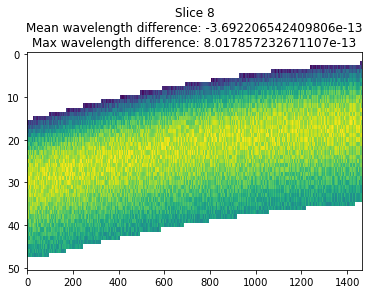

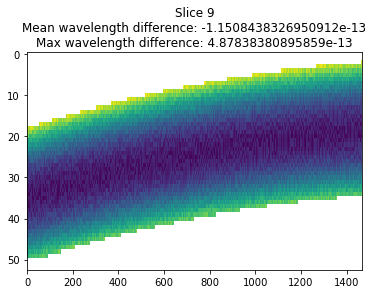

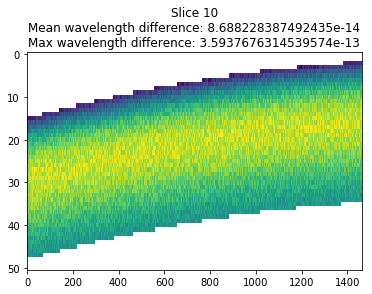

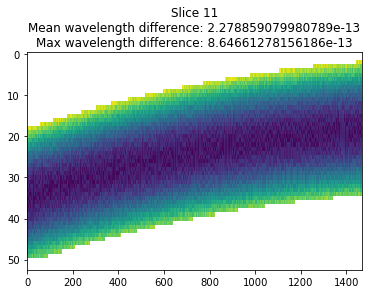

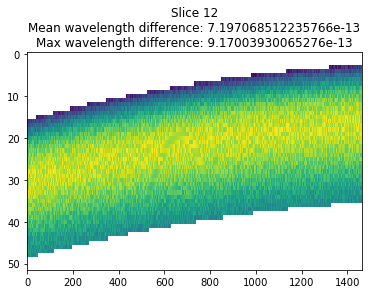

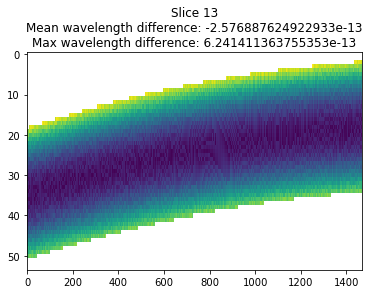

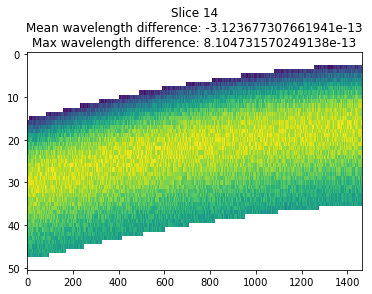

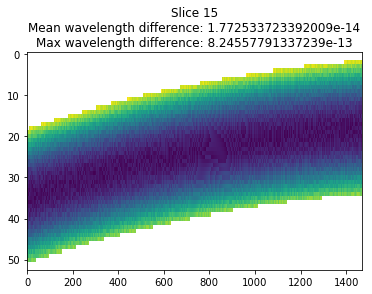

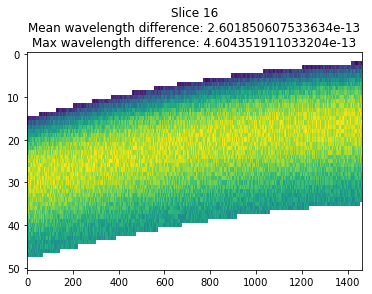

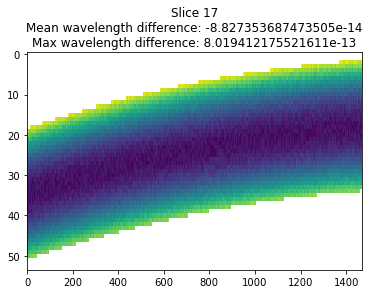

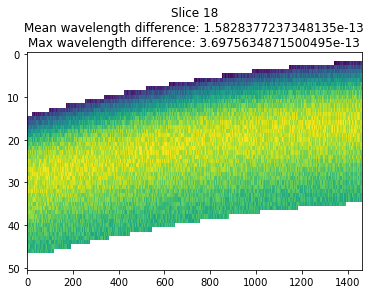

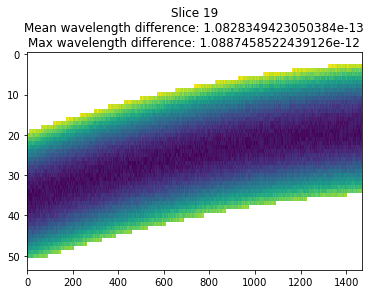

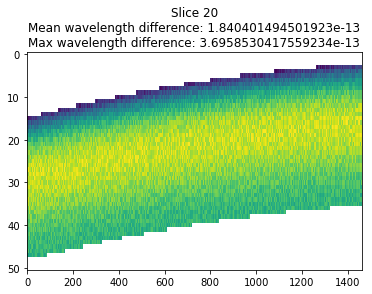

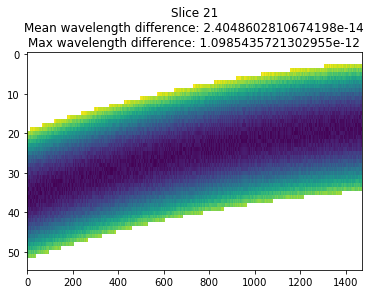

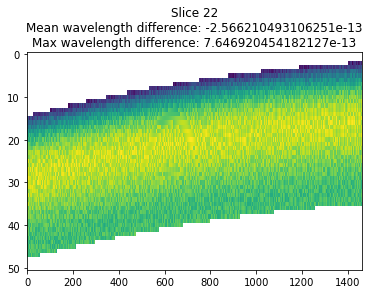

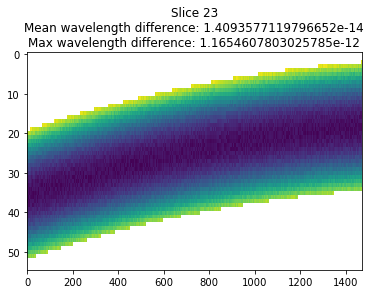

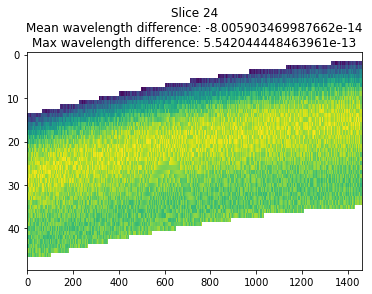

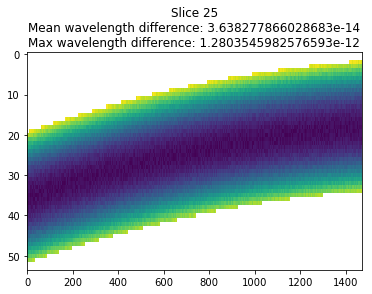

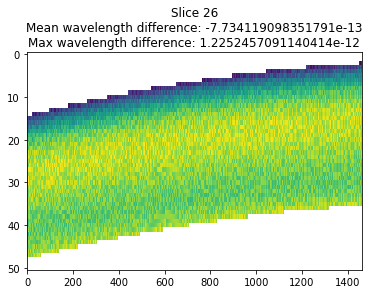

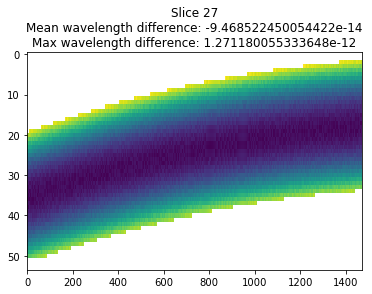

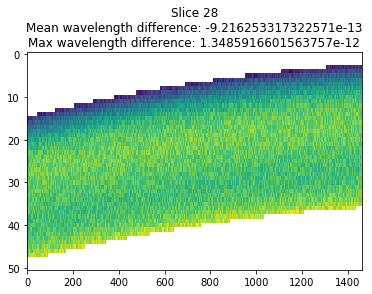

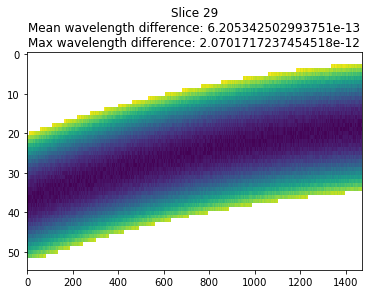

In [6]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("ifu_assign_wcs.fits")
for trace in esa:
    s = fits.getval(trace, 'SLICEID')
    
    # get the WCS object of this slice
    slice_w = nirspec.nrs_wcs_set_input(im, s)

    diff = test_nrs_ifu.test_wavelength(slice_w, trace)
    
    title = "Slice {0}".format(s)
    title += "\nMean wavelength difference: {0}".format(diff[~np.isnan(diff)].mean())
    title += "\nMax wavelength difference: {0}".format(np.abs(diff)[~np.isnan(diff)].max())
    plt.title(title)
    plt.imshow(diff, aspect='auto')
    plt.show()


### Test 3 - using compute_world_coordinates

The file was created by running the following commands:

```
from jwst.assign_wcs.tools.nirspec import compute_world_coordinates
compute_world_coordinates.ifu_coords("ifu_assign_wcs.fits")
```
The goal of this test is to confirm that the FITS WCS written in the output file header is correct.
The (x0, y0) indices used to compute and populate the arrays in compute_world_coordinates were written out 
as a 5th and 6th plane in each extension. This test compares the (x0, y0) indices with the indices computed using
the FITS WCS in the header.

Note: compute_world_coordinates is not officially supported in the pipeline but is used by the INS team for testing.

In [12]:
# Here's what the file looks like
fwc = fits.open('ifu_world_coordinates.fits')
print(fwc.info())

Filename: ifu_world_coordinates.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 ImageHDU        21   (1464, 48, 6)   float64   
  2                1 ImageHDU        21   (1466, 50, 6)   float64   
  3                1 ImageHDU        21   (1463, 49, 6)   float64   
  4                1 ImageHDU        21   (1467, 50, 6)   float64   
  5                1 ImageHDU        21   (1464, 48, 6)   float64   
  6                1 ImageHDU        21   (1467, 51, 6)   float64   
  7                1 ImageHDU        21   (1464, 48, 6)   float64   
  8                1 ImageHDU        21   (1468, 50, 6)   float64   
  9                1 ImageHDU        21   (1463, 48, 6)   float64   
 10                1 ImageHDU        21   (1467, 51, 6)   float64   
 11                1 ImageHDU        21   (1463, 48, 6)   float64   
 12                1 ImageHDU        21   (1468, 51, 6)   float64   
 13                1 I

In [13]:
# And here's the header with each plane info
fwc[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1464                                                  
NAXIS2  =                   48                                                  
NAXIS3  =                    6                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
PLANE1  = 'lambda, microns'                                                     
PLANE2  = 'world_x, arcsec'                                                     
PLANE3  = 'world_y, arcsec'                                                     
PLANE4  = 'slit_y, relative to center (0, 0)'                                   
PLANE5  = 'x, pix  '        

In [56]:
# Read the (x0, y0) planes. These are the inputs with which the wavelength was computed.
# For Slice 0

data = fwc[1].data
x0 = data[4]
y0 = data[5]

In [57]:
# Now recreate these arrays using the FITS WCS in the header 
from astropy import wcs
shape = data[0].shape
y, x = np.mgrid[:shape[0], :shape[1]]

w = wcs.WCS(fwc[1].header)
w0 = w.sub(axes=2) # This is a cube, so take the first two axes

In [61]:
# Compute x,y using the WCS object
xres, yres = w0.all_pix2world(x, y, 1)

In [62]:
xres

array([[  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       ..., 
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.]])

In [63]:
x0

array([[  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       ..., 
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.],
       [  124.,   125.,   126., ...,  1585.,  1586.,  1587.]])

One thing to note here is that (x0, y0) are 0-based and so the wavelength array was computed with 0-based coordinates.
This is how we want the pipeline to work.
The other tests show that the agreement with ESA traces is with 1-based coordinates.

In [64]:
yres

array([[ 777.,  777.,  777., ...,  777.,  777.,  777.],
       [ 778.,  778.,  778., ...,  778.,  778.,  778.],
       [ 779.,  779.,  779., ...,  779.,  779.,  779.],
       ..., 
       [ 822.,  822.,  822., ...,  822.,  822.,  822.],
       [ 823.,  823.,  823., ...,  823.,  823.,  823.],
       [ 824.,  824.,  824., ...,  824.,  824.,  824.]])

In [66]:
y0

array([[ 777.,  777.,  777., ...,  777.,  777.,  777.],
       [ 778.,  778.,  778., ...,  778.,  778.,  778.],
       [ 779.,  779.,  779., ...,  779.,  779.,  779.],
       ..., 
       [ 822.,  822.,  822., ...,  822.,  822.,  822.],
       [ 823.,  823.,  823., ...,  823.,  823.,  823.],
       [ 824.,  824.,  824., ...,  824.,  824.,  824.]])